In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid

In [2]:
# COMAP
zmin = 2.4
zmax = 3.4
line_str = 'CO'

Omega_field = 2.5 * (np.pi/180)**2 #rad^2
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [3]:
from LIMxCMBL.experiments import *
_a, _b = COMAP_Pei()
print(_a, _b)
Pei = np.array(_a) # kJy2 Mpc3 / sr2
print(Pei)

52.84337535246153 kJy2 Mpc3 / sr2 64.99303792382938 kJy2 Mpc3 / sr2
52.84337535246153


In [4]:
n_bins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [5]:
import matplotlib.pyplot as plt

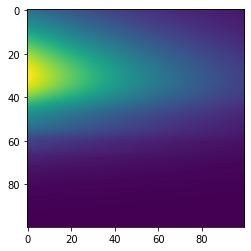

In [6]:
I_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_'
I_kappa_fname +='zmin_%.5f_zmax_%.5f_quad_next_%d.npy'%(zmin, 
                                                        zmax, 
                                                        1000)

I_kappa_unbinned = np.load(I_kappa_fname)

I_kappa = np.zeros((len(ells), n_bins))
external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 1000)
for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            I_kappa[:,i] = (np.sum(I_kappa_unbinned[:,idx1[0]:idx1[-1]+1,], 
                                 axis=(1)) / len(idx1))
            
plt.imshow(I_kappa)

In [7]:
print(np.max(np.abs(I_kappa)))

1.3274911410610771e-08


In [8]:
def get_binned(base, n_external = 300):
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
    
    oup = np.zeros((100, n_bins, n_bins), dtype=np.float64)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
            oup[:,i,j] = (np.sum(base[:,
                                      idx1[0]:idx1[-1]+1,
                                      idx2[0]:idx2[-1]+1], 
                                 axis=(1, 2)) / len(idx1) / len(idx2))
    return oup

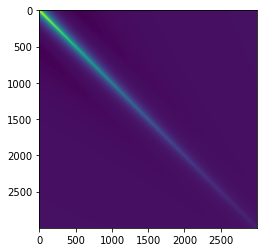

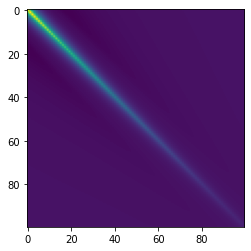

In [9]:
#get <II>

I_I_unbinned = np.load('/scratch/users/delon/LIMxCMBL/I_auto/'+
                          'I_auto_n_ext_%d_zmin_%.1f_zmax_%.1f.npy'%(3000, 
                                                                     zmin, 
                                                                     zmax))

plt.imshow(I_I_unbinned[0])
plt.show()
I_I = get_binned(I_I_unbinned, n_external = 3000)
plt.imshow(I_I[0])

[]

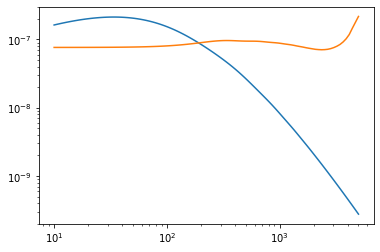

In [10]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [11]:
from tqdm import tqdm

In [12]:
SNR2_per_mode_full = {}
SNR2_per_mode_noise_dom = {}

# full cov no filtering SNR per mode

In [13]:
from LIMxCMBL.noise import f_eIeI
cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0)))
cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  I_I)
cov += np.einsum('lx ,l y->lxy', I_kappa, I_kappa)
cov = cov.astype(np.float64)

SNR2_per_mode_full[0.0] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, I_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_full[0.0][ell_idx] = np.dot(I_kappa[ell_idx], x)

# noise dom no filtering SNR per mode

In [14]:
from LIMxCMBL.noise import f_eIeI
cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0)))
cov = cov.astype(np.float64)

SNR2_per_mode_noise_dom[0.0] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, I_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_noise_dom[0.0][ell_idx] = np.dot(I_kappa[ell_idx], x)

# SNR per mode with filtering

In [15]:
from tqdm import trange

In [22]:

for Lambda_idx in range(24, 25):
    Lambda = Lambdas[Lambda_idx]
    if(Lambda < 2* np.pi/(chimax-chimin)):
        continue
    print(Lambda_idx)
    #IHi_kappa##########################################
    ILo_kappa = np.zeros((100, n_bins))

    for curr_bin in range(n_bins):
        oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(zmin, zmax, 
                                                                                                                            Lambda_idx, n_bins, 
                                                                                                                            curr_bin)
        ILo_kappa[:,curr_bin] = np.load(oup_fname)


    IHi_kappa = I_kappa - ILo_kappa
    ####################################################
    #IHi_IHi############################################
    IHiIHi = np.zeros((len(ells), n_bins, n_bins))

    for idx1 in trange(n_bins):
        for idx2 in range(idx1, n_bins):
            IHiIHi_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_'
            IHiIHi_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_%d_%d_jax_qmc.npy'%(line_str,
                                                                                            zmin, zmax, 
                                                                                            Lambda_idx, 
                                                                                            n_bins,idx1, idx2)

            IHiIHi[:, idx1, idx2] = np.load(IHiIHi_fname)
            IHiIHi[:, idx2, idx1] = IHiIHi[:, idx1, idx2]

    ####################################################
    #eHI eHI############################################
    eComb_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_comb_'
    eComb_fname +='zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, 
                                                                               zmax, 
                                                                               Lambda_idx, 
                                                                               n_bins)
    eComb = np.load(eComb_fname)
    eHIeHI_binned = eComb
    ####################################################
    #full cov###########################################
    #l -> ells
    #x -> chi
    #y -> chi'
    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  IHiIHi)
    cov += np.einsum('lx ,l y->lxy', IHi_kappa, IHi_kappa)
    cov = cov.astype(np.float64)

    SNR2_per_mode_full[Lambda] = np.zeros_like(ells)
    for ell_idx in trange(len(ells)):
        try:
            L = np.linalg.cholesky(cov[ell_idx])
            y = np.linalg.solve(L, IHi_kappa[ell_idx])
            x = np.linalg.solve(L.T, y)
            SNR2_per_mode_full[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
        except:
            print(ell_idx)
            x, residuals, rank, s = np.linalg.lstsq((cov[ell_idx]), 
                                                    IHi_kappa[ell_idx], rcond=-1)
            SNR2_per_mode_full[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
    ####################################################
    #noise-dom cov######################################
    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov = cov.astype(np.float64)
    SNR2_per_mode_noise_dom[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode_noise_dom[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
    ####################################################
    ####################################################

24


  5%|▌         | 5/100 [00:00<00:12,  7.38it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/delon/LIMxCMBL/I_auto/comb_CO_zmin_2.4_zmax_3.4_Lambda_idx_24_n_b_100_5_69_jax_qmc.npy'

In [ ]:

for Lambda_idx in range(24, 25):
    Lambda = Lambdas[Lambda_idx]

    cross = np.zeros((len(ells), n_bins, n_bins))
    auto = np.zeros((len(ells), n_bins, n_bins))

    for idx1 in trange(n_bins):
        for idx2 in range(idx1, n_bins):
            cross_fname = '/scratch/users/delon/LIMxCMBL/I_auto/2025-03-25-try2/cross_'
            cross_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_%d_%d_jax_qmc.npy'%(line_str,
                                                                                            zmin, zmax, 
                                                                                            Lambda_idx, 
                                                                                            n_bins,idx1, idx2)
            cross_fname += 'relerr.npy'
            cross[:, idx1, idx2] = np.load(cross_fname)
            
            auto_fname = '/scratch/users/delon/LIMxCMBL/I_auto/lolo_'
            auto_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_%d_%d_jax_qmc.npy'%(line_str,
                                                                                            zmin, zmax, 
                                                                                            Lambda_idx, 
                                                                                            n_bins,idx1, idx2)

            auto_fname += 'relerr.npy'
            auto[:, idx1, idx2] = np.load(auto_fname)


In [ ]:
Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

In [ ]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode_full)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

In [ ]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
#     if(Lambda < 2*np.pi/(chimax - chimin)):
#         continue

    label = None
    if(Lambda == 1e-5 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

    
    
plt.xscale('log')
plt.xlabel('ells')
plt.title('binned full cov')
plt.ylabel(r'$\ell^2\times$(snr2 per mode)')
plt.legend(frameon=False)

In [ ]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
#     if(Lambda < 2*np.pi/(chimax - chimin)):
#         continue
    label = None
    if(Lambda == 1e-5 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_noise_dom[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.title('binned noise dom(only Lambda > 2 pi / Dchi)')
plt.ylabel(r'$\ell^2\times$(snr2 per mode)')
plt.legend(frameon=False)

In [ ]:
#new calculation
SNR2_per_Omega_full      = np.zeros(len(Lambdas))
SNR2_per_Omega_noise_dom = np.zeros(len(Lambdas))

for Lambda_idx,Lambda in enumerate(Lambdas):
    SNR2_per_Omega_noise_dom[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                     y = SNR2_per_mode_noise_dom[Lambda] 
                                                     * ells ** 2 
                                                     / 2 / np.pi)
    
    SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                y = SNR2_per_mode_full[Lambda] 
                                                * ells ** 2 
                                                / 2 / np.pi)
    

In [ ]:
SNR2_per_Omega_full

In [ ]:
plt.figure(figsize = (5,5) ,dpi = 300, facecolor = 'w')


# this is to throw out the SNR2 computed for Lambda ~ the fundamental 
# which is where things may go wrong
_idxs = np.where(SNR2_per_Omega_noise_dom < SNR2_per_Omega_noise_dom[0])


plt.scatter(Lambdas[_idxs], np.sqrt(SNR2_per_Omega_noise_dom[_idxs] * Omega_field), 
         c='r',
            marker='+',s=50,
        label='noise dom')
plt.axhline(np.sqrt(SNR2_per_Omega_noise_dom[0] * Omega_field))

plt.scatter(Lambdas[_idxs], np.sqrt(SNR2_per_Omega_full[_idxs] * Omega_field), 
         c='k',
            marker='x', s=50,
        label='full cov')
plt.axhline(np.sqrt(SNR2_per_Omega_full[0] * Omega_field), c='k')


# Omega_halfsky = 20000 * (np.pi/180)**2 #rad^2
# plt.scatter(Lambdas[_idxs], np.sqrt(SNR2_per_Omega_full[_idxs] * Omega_halfsky), 
#          c='lightgrey',
#             marker='x', s=50,
#         label='full cov + half sky')

fundamental = 2*np.pi/(chimax - chimin)
# plt.axvline(fundamental, c='lightgrey')
# plt.xscale('symlog', linthresh = 5 * fundamental)
plt.xscale('log')
# plt.yscale('log')
plt.xlim(fundamental, 1e-1)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'${\sf SNR}$')
plt.title('COMAP ')
plt.legend(frameon=False, loc = 'upper right')